In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

2024-04-29 01:36:11.675400: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 01:36:11.675444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 01:36:11.676129: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-29 01:36:11.681334: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 01:36:12.292917: W tensorflow/compiler/tf2

In [2]:
# Load the Google stock prices dataset
df = pd.read_csv('./data/google.csv')

# Extract the 'Close' prices
data = df['Open'].values.reshape(-1, 1)

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume
0,01/03/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,01/04/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,01/05/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,01/06/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,01/09/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)

In [5]:
# Split the data into training and testing sets
train_size = int(len(data_normalized) * 0.8)
test_size = len(data_normalized) - train_size
train_data, test_data = data_normalized[0:train_size,:], data_normalized[train_size:len(data_normalized),:]

In [6]:
train_size, test_size

(1207, 302)

In [7]:
# Convert the time series data into sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # input sequence
        y.append(data[i + seq_length])  # target (y)
    return np.array(X), np.array(y)

In [8]:
seq_length = 10  # Sequence length
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [9]:
# Build the RNN model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(units=50, return_sequences = True),
    LSTM(units=50, return_sequences = True),
    LSTM(units = 50, return_sequences = False),
    Dense(units=1)
])


In [10]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 (277.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [11]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
38/38 [==============================] - 4s 14ms/step - loss: 0.0281
Epoch 2/10
38/38 [==============================] - 1s 15ms/step - loss: 0.0013
Epoch 3/10
38/38 [==============================] - 1s 16ms/step - loss: 7.2040e-04
Epoch 4/10
38/38 [==============================] - 1s 16ms/step - loss: 6.2295e-04
Epoch 5/10
38/38 [==============================] - 1s 16ms/step - loss: 6.2197e-04
Epoch 6/10
38/38 [==============================] - 1s 16ms/step - loss: 6.3793e-04
Epoch 7/10
38/38 [==============================] - 1s 16ms/step - loss: 6.3127e-04
Epoch 8/10
38/38 [==============================] - 1s 16ms/step - loss: 6.0210e-04
Epoch 9/10
38/38 [==============================] - 1s 16ms/step - loss: 6.0687e-04
Epoch 10/10
38/38 [==============================] - 1s 15ms/step - loss: 6.1892e-04


In [12]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)


10/10 [==============================] - 0s 6ms/step


In [13]:
# Inverse normalize the predictions
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train)
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

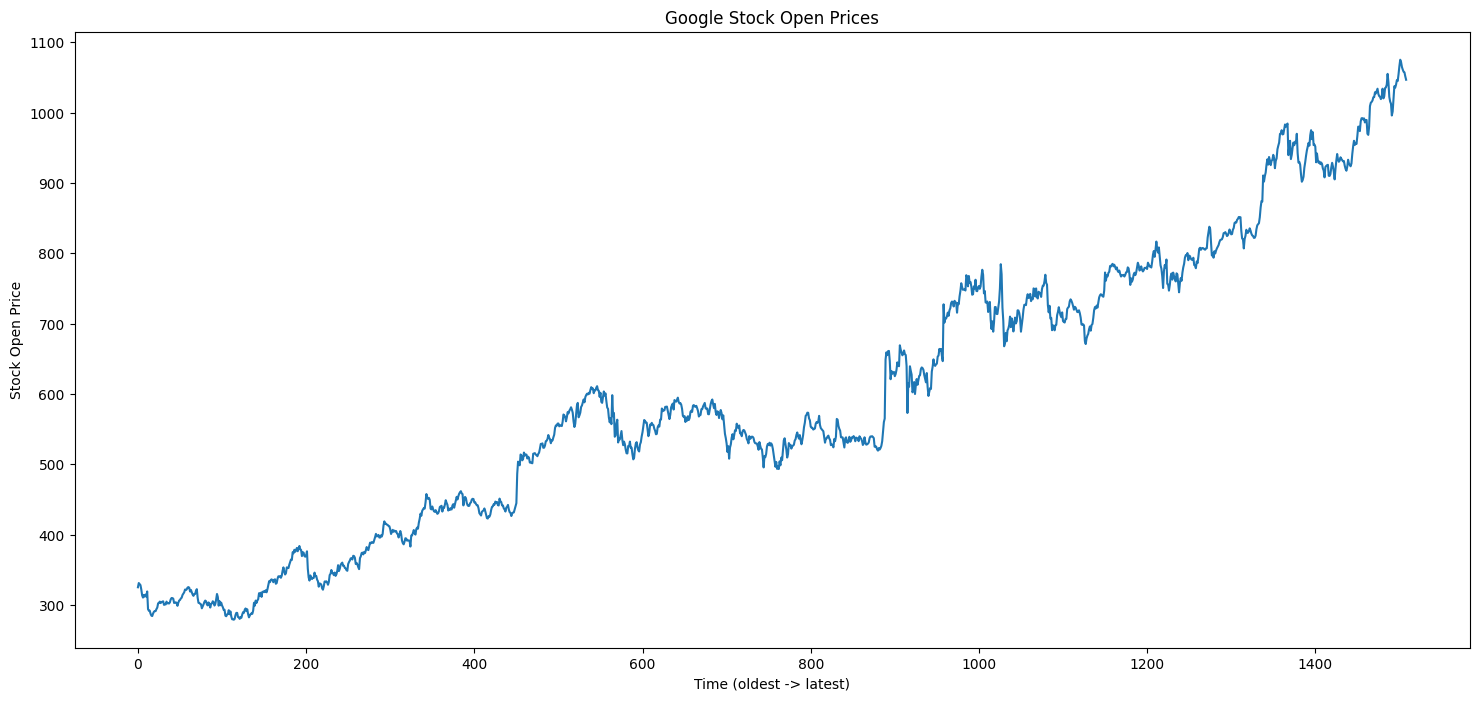

In [14]:
plt.figure(figsize=(18, 8))
plt.plot(df['Open'])
plt.title("Google Stock Open Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Open Price")
plt.show()

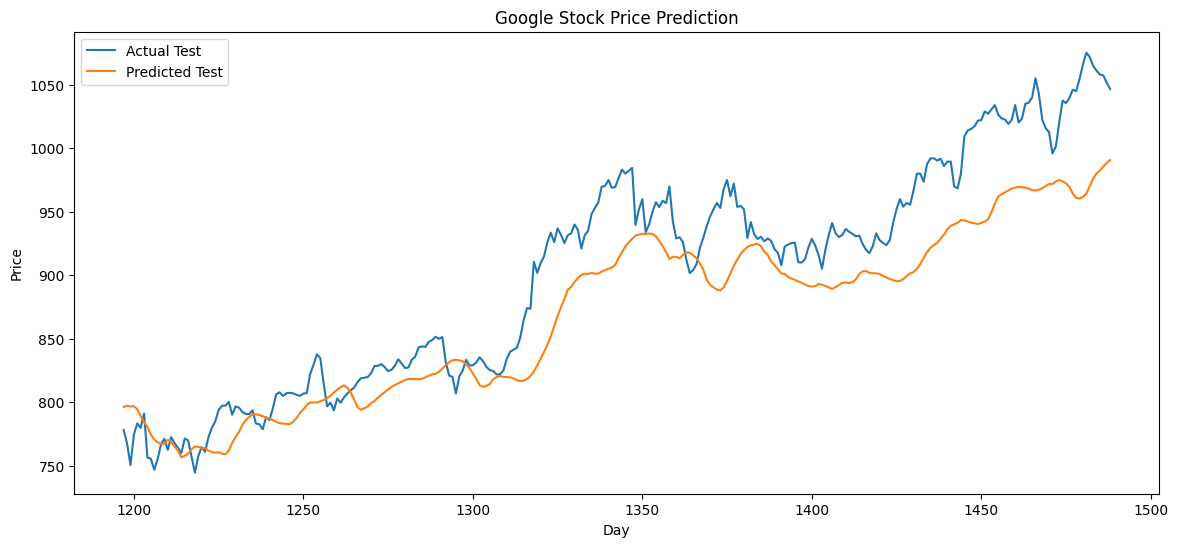

In [15]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual Test')

plt.plot(np.arange(len(train_predictions), len(train_predictions) + len(test_predictions)), test_predictions, label='Predicted Test')

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Google Stock Price Prediction')
plt.legend()
plt.show()